3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


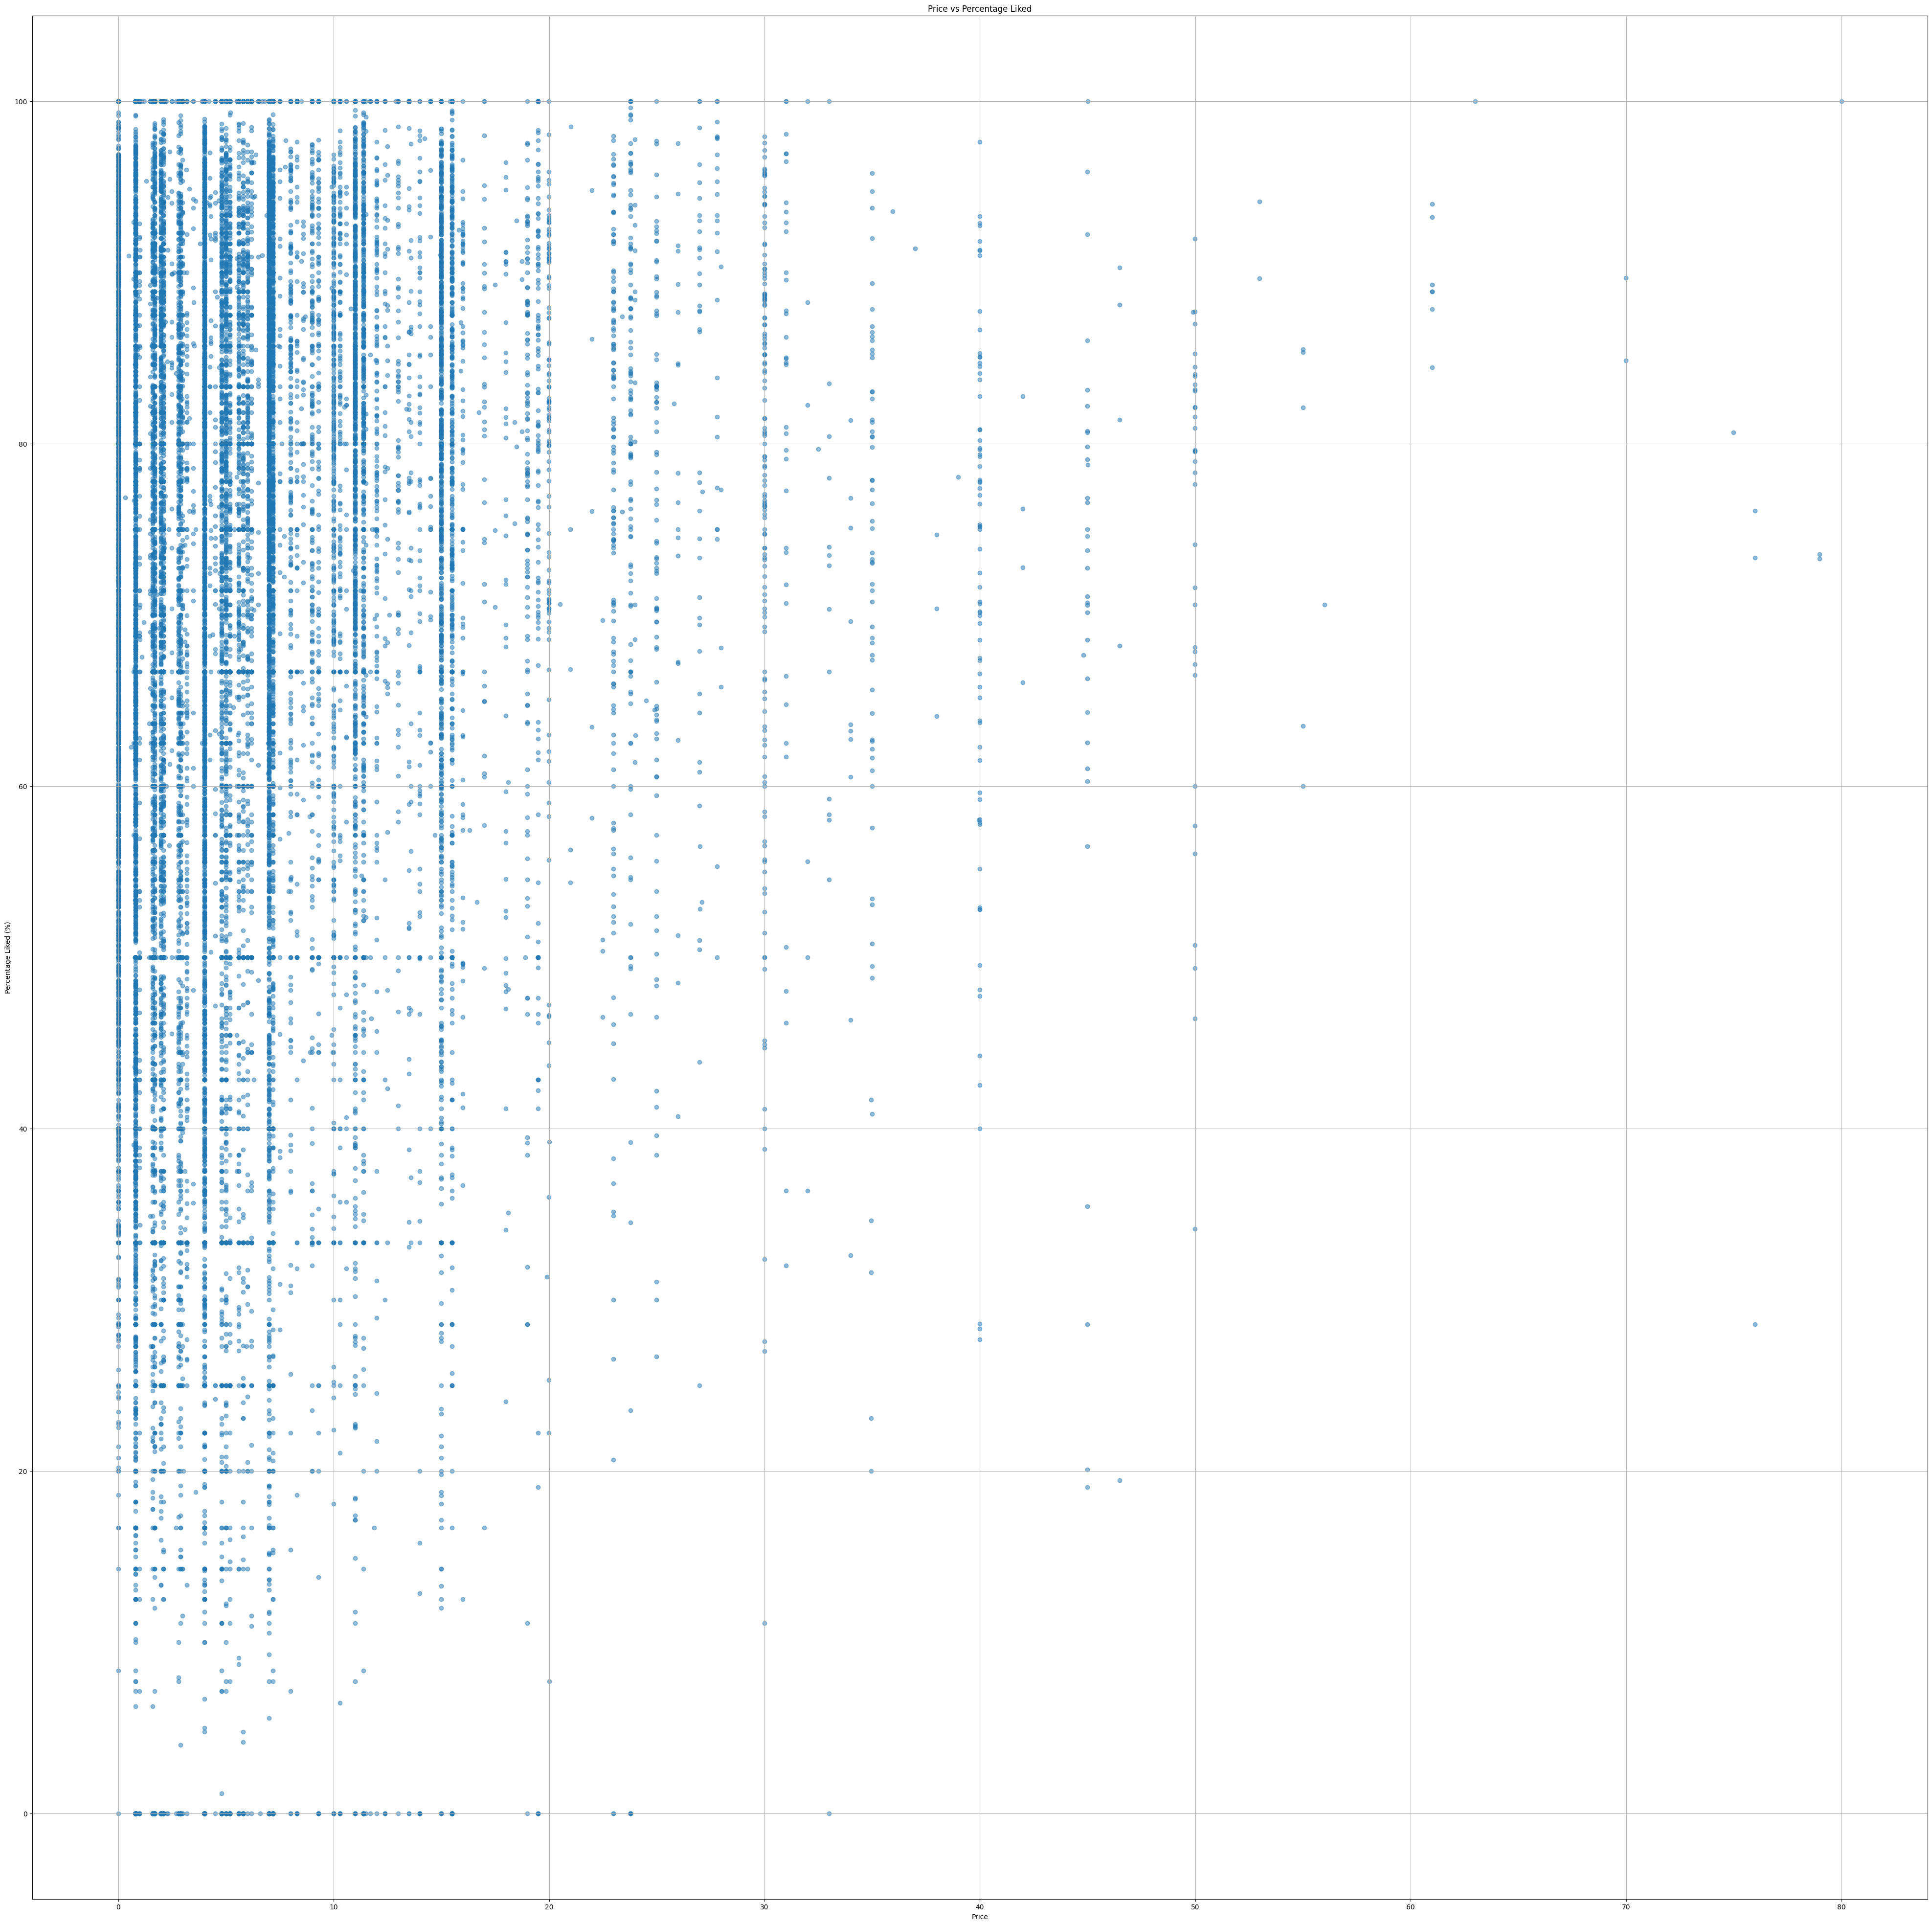

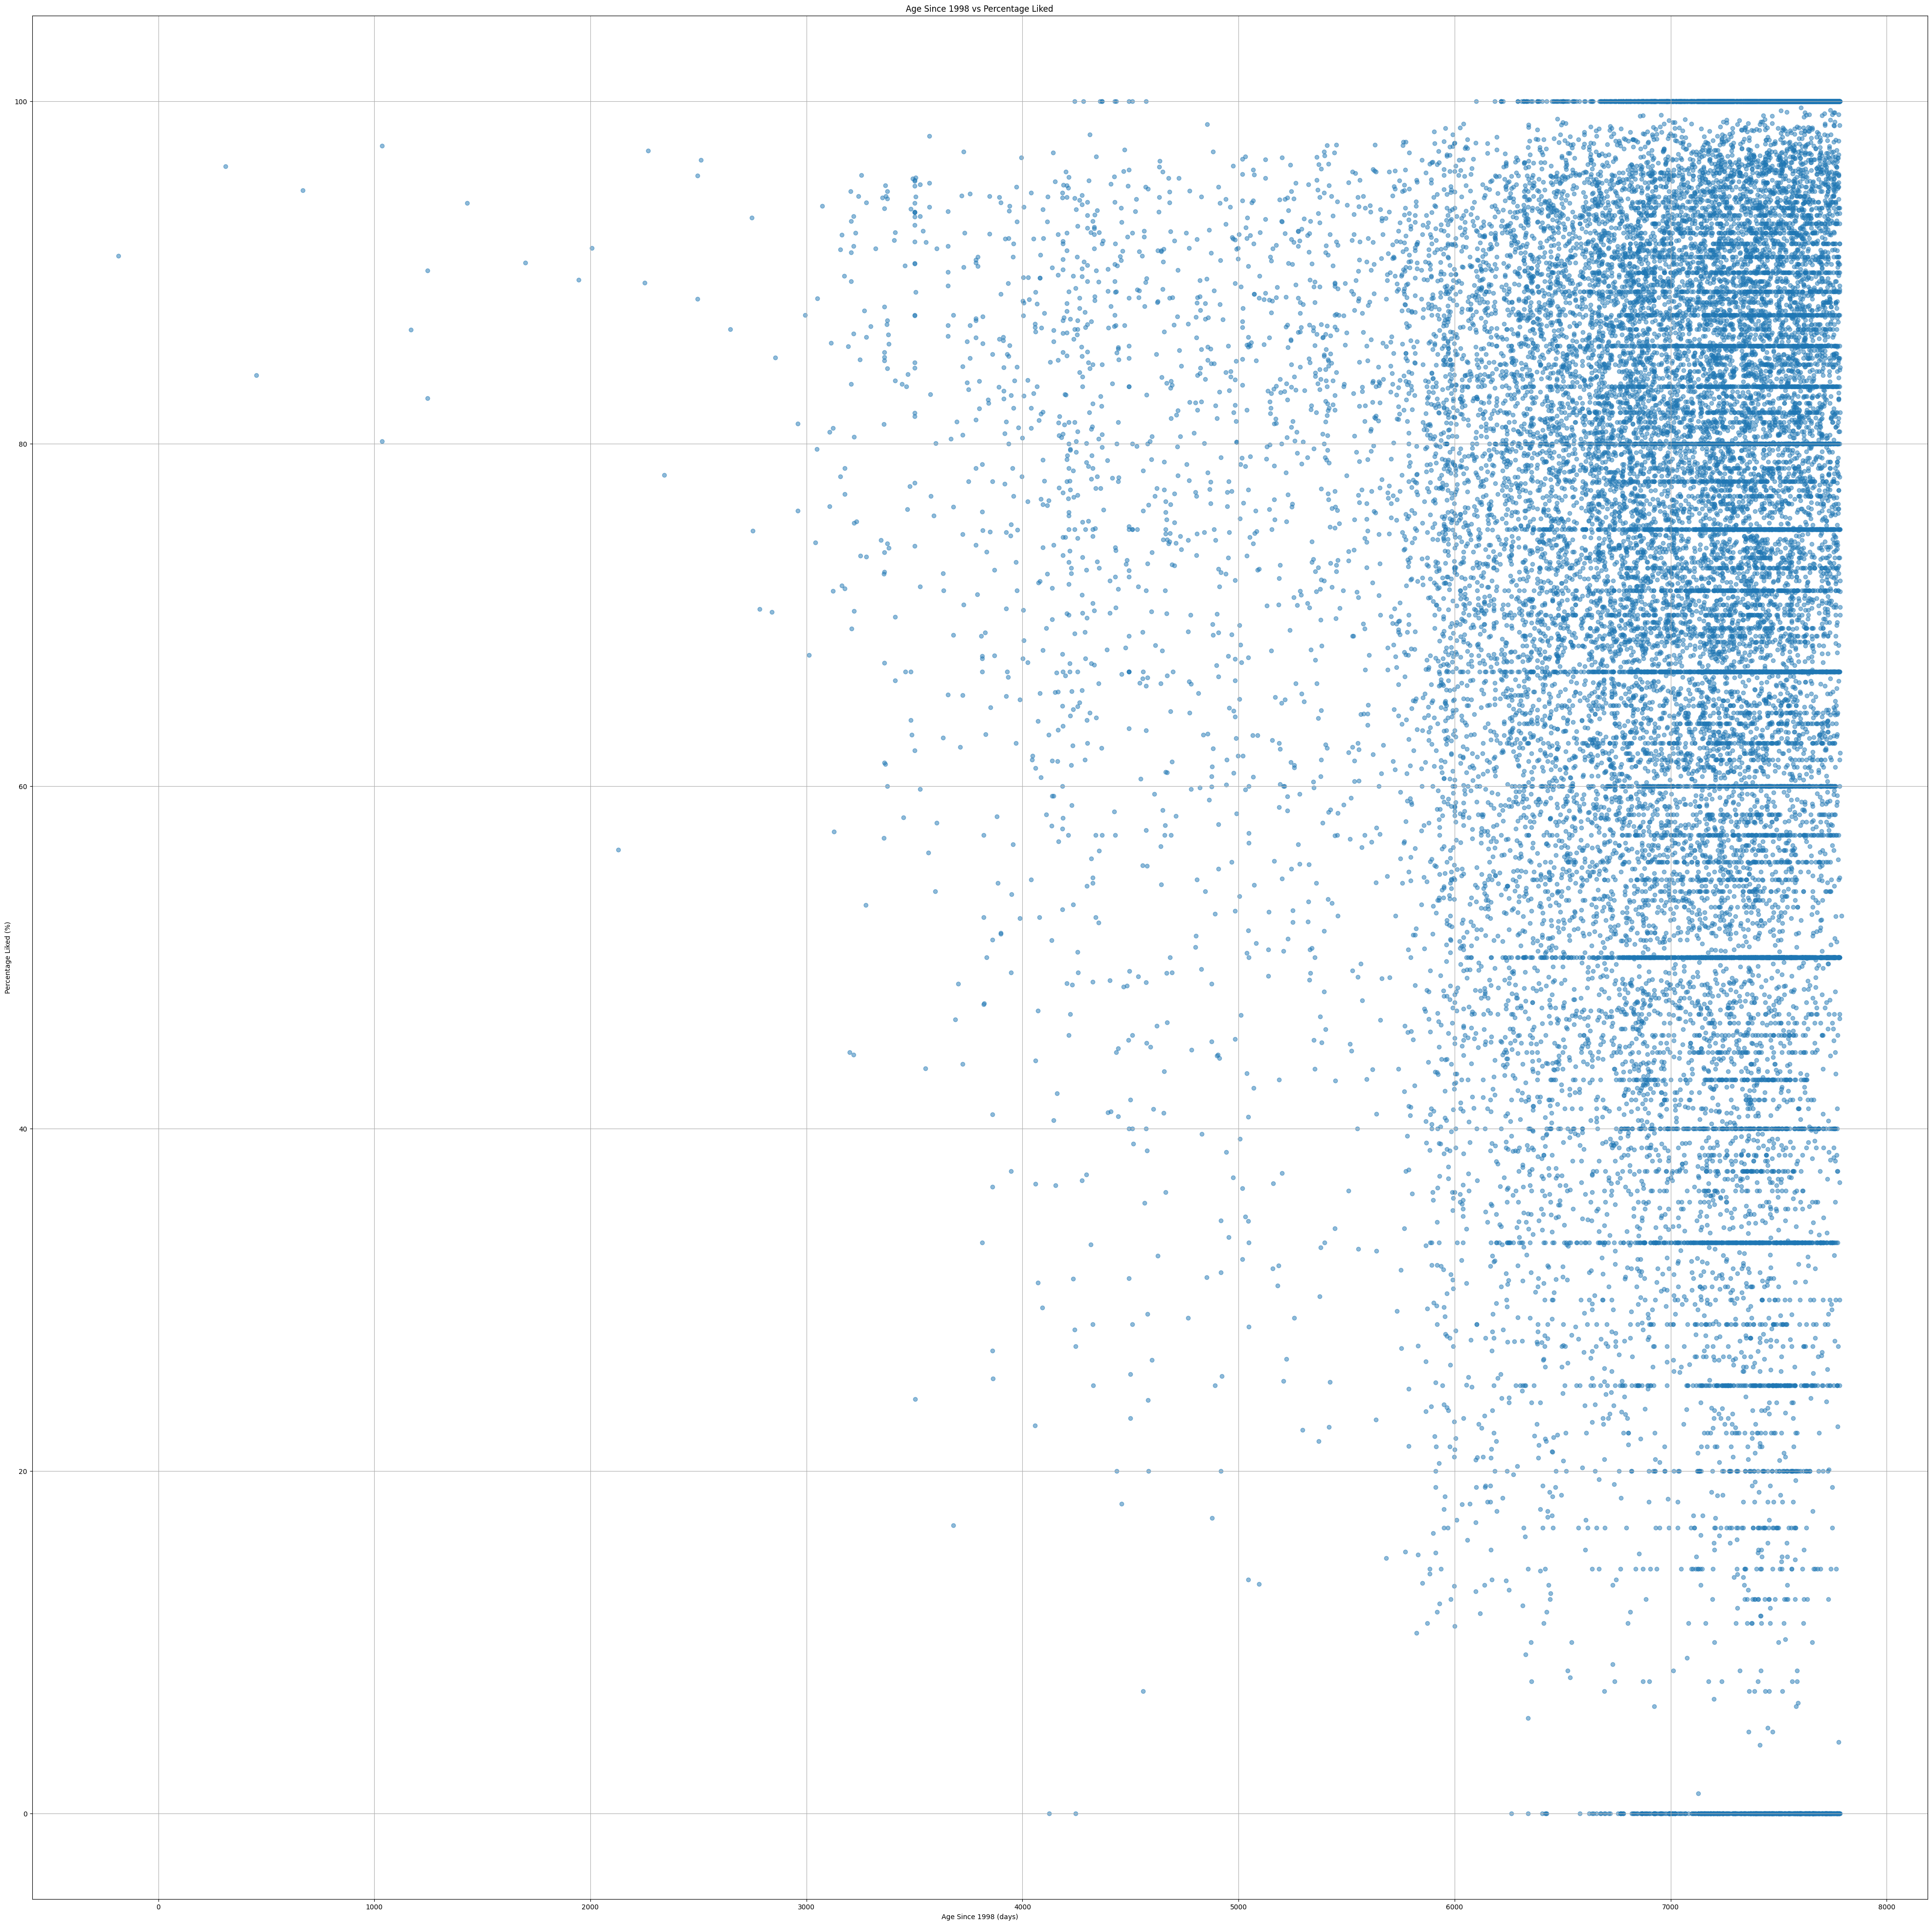

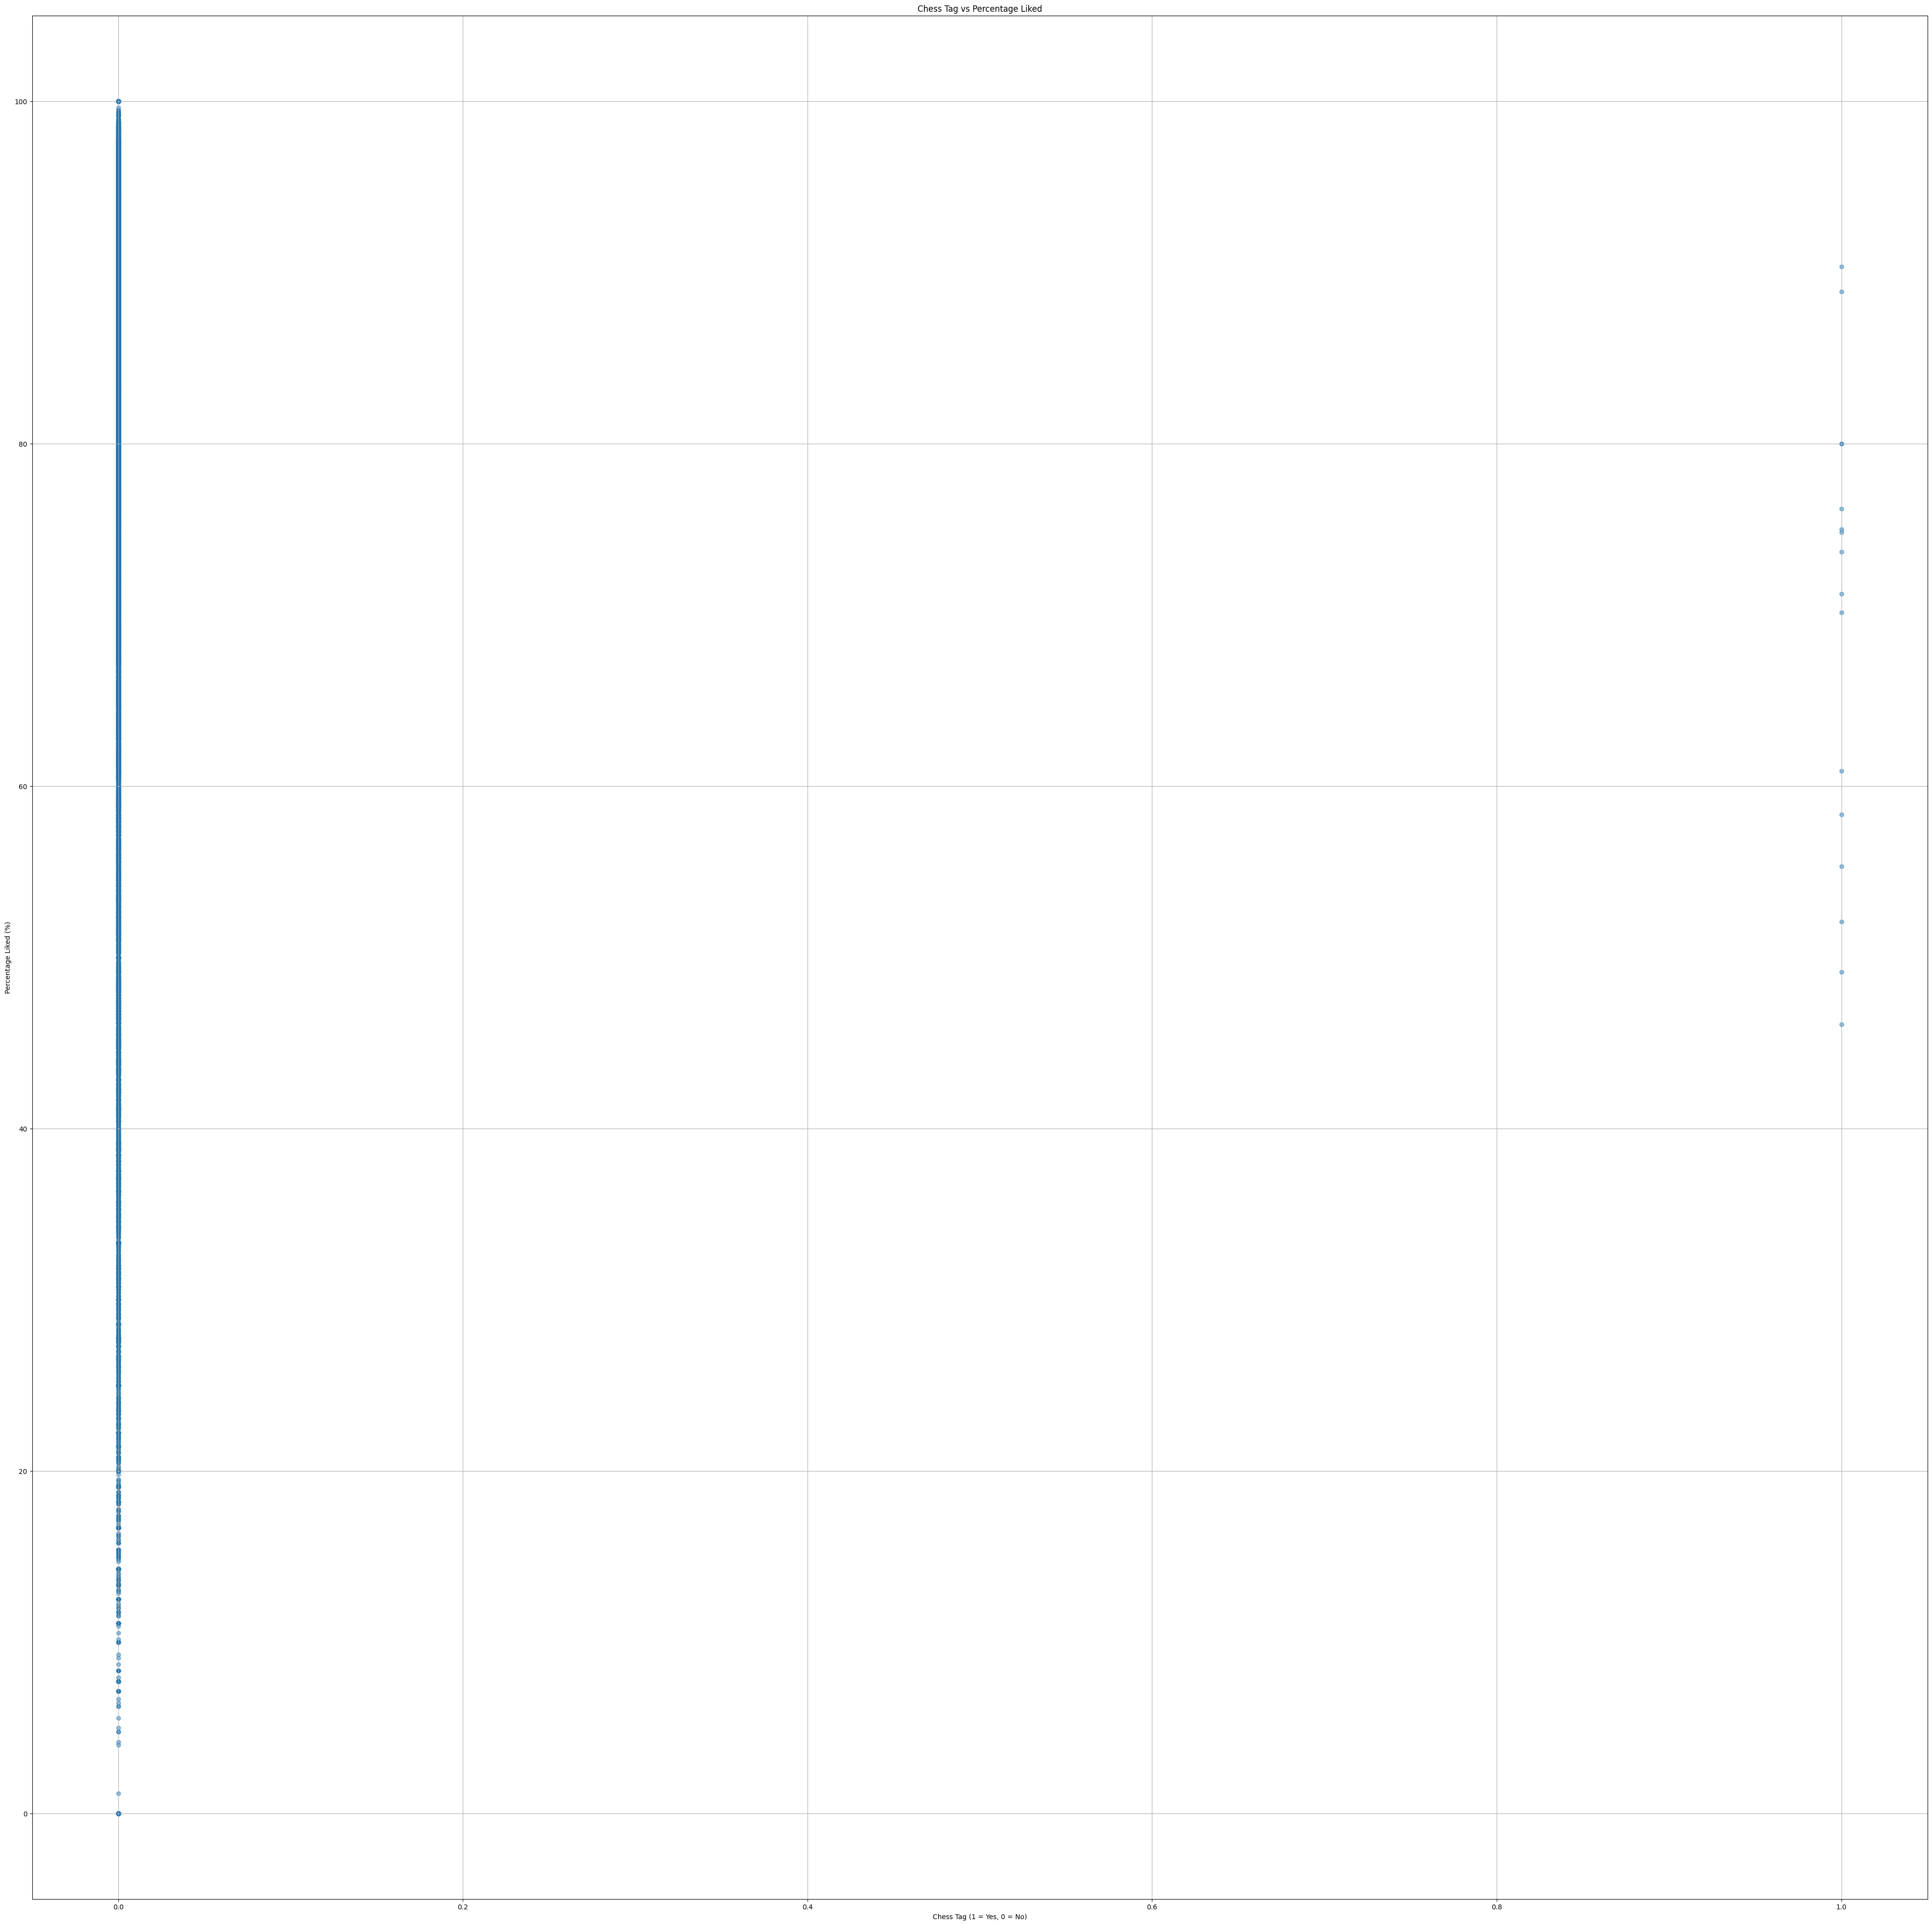

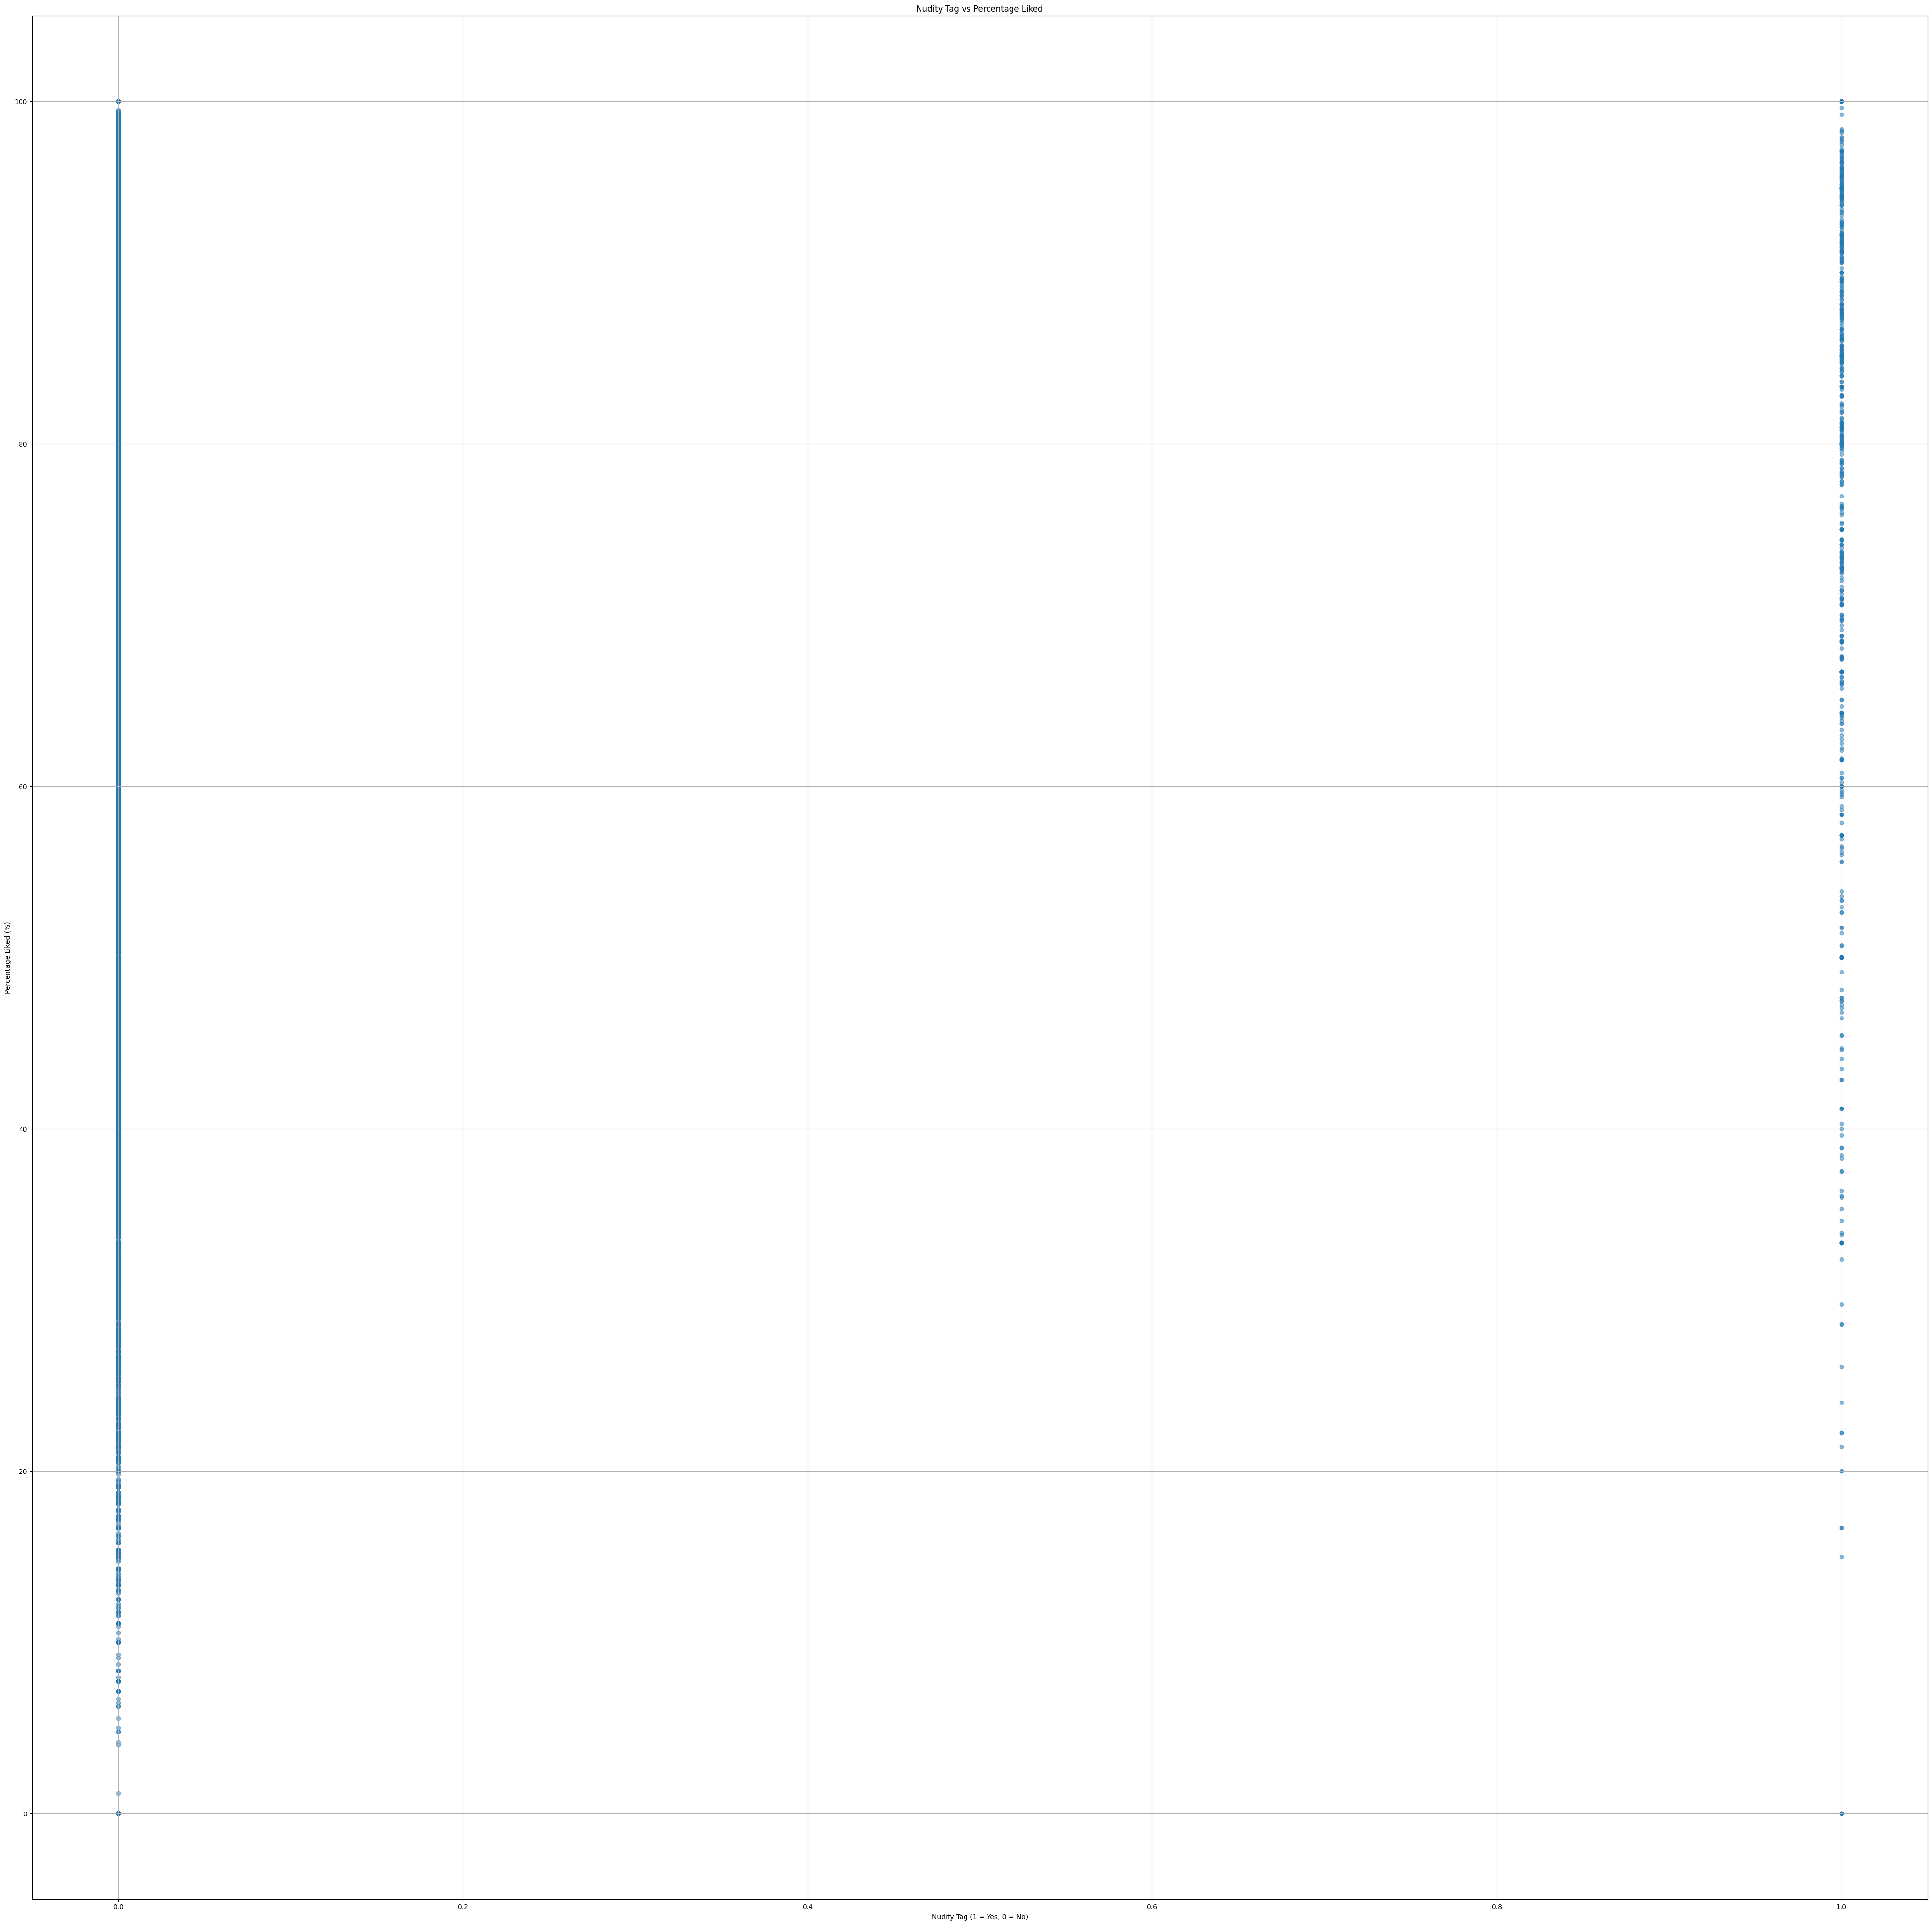

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys

print(sys.version)


def one_hot_multilabel(df, col, sep=";", prefix=None):
    if col not in df.columns:
        return df
    # ensure string, fill NaNs as empty
    s = df[col].fillna("").astype(str)
    dummies = s.str.get_dummies(sep=sep)
    if prefix:
        dummies = dummies.add_prefix(prefix)
    return pd.concat([df, dummies], axis=1)


def one_hot_top_n(df, col, top_n=50, prefix=None):
    if col not in df.columns:
        return df

    s = df[col].fillna("Unknown").astype(str)

    # pick top N most frequent
    top = s.value_counts().head(top_n).index
    s_bkt = s.where(s.isin(top), other="Other")

    dummies = pd.get_dummies(s_bkt, prefix=prefix or col, dtype=np.int8)
    return pd.concat([df, dummies], axis=1)


df = pd.read_csv("data\steam.csv")


df["percentage_liked"] = df["positive_ratings"] / (df["positive_ratings"] + df["negative_ratings"]) * 100

df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
origin = pd.Timestamp("1998-01-01")
df["age_since_1998"] = (df["release_date"] - origin).dt.days


owners_split = df['owners'].str.split('-', expand=True).astype(int)
df['owners'] = owners_split.mean(axis=1)

df = df[df['price'] <= 80]

tags_dummies = df["steamspy_tags"].str.get_dummies(sep=";")
df_expanded = pd.concat([df, tags_dummies], axis=1)


df_expanded.to_csv("output.csv", index=False)
new_df = pd.read_csv("output.csv")


new_df = one_hot_multilabel(new_df, "platforms", sep=";", prefix="platform_")
new_df = one_hot_multilabel(new_df, "categories", sep=";", prefix="cat_")
new_df = one_hot_multilabel(new_df, "genres", sep=";", prefix="genre_")

new_df = one_hot_top_n(new_df, "developer", top_n=50, prefix="dev")
new_df = one_hot_top_n(new_df, "publisher", top_n=50, prefix="pub")


if "achievements" in new_df.columns:
    new_df["has_achievements"] = (new_df["achievements"].fillna(0) > 0).astype(np.int8)

if "required_age" in new_df.columns:
    new_df["has_required_age_restriction"] = (new_df["required_age"].fillna(0) > 0).astype(np.int8)

if "price" in new_df.columns:
    new_df["is_free"] = (new_df["price"].fillna(0) == 0).astype(np.int8)

if "average_playtime" in new_df.columns:
    new_df["has_playtime"] = (new_df["average_playtime"].fillna(0) > 0).astype(np.int8)


drop_cols = [
    "steamspy_tags",
    "genres",
    "categories",
    "platforms",
    "developer",
    "publisher",
    "name",
    "appid",
    "release_date",
    "positive_ratings",
    "negative_ratings",
]

drop_cols = [c for c in drop_cols if c in new_df.columns]
new_df = new_df.drop(columns=drop_cols)



plt.figure(figsize=(50, 50))
plt.scatter(new_df['price'], new_df['percentage_liked'], alpha=0.5)
plt.title('Price vs Percentage Liked')
plt.xlabel('Price')
plt.ylabel('Percentage Liked (%)')
plt.grid(True)
plt.show()


plt.figure(figsize=(50, 50))
plt.scatter(new_df['age_since_1998'], new_df['percentage_liked'], alpha=0.5)
plt.title('Age Since 1998 vs Percentage Liked')
plt.xlabel('Age Since 1998 (days)')
plt.ylabel('Percentage Liked (%)')
plt.grid(True)
plt.show()


# chess vs percentage liked
plt.figure(figsize=(50, 50))
plt.scatter(new_df['Chess'], new_df['percentage_liked'], alpha=0.5)
plt.title('Chess Tag vs Percentage Liked')
plt.xlabel('Chess Tag (1 = Yes, 0 = No)')
plt.ylabel('Percentage Liked (%)')
plt.grid(True)
plt.show()


# nudity vs percentage liked
plt.figure(figsize=(50, 50))
plt.scatter(new_df['Nudity'], new_df['percentage_liked'], alpha=0.5)
plt.title('Nudity Tag vs Percentage Liked')
plt.xlabel('Nudity Tag (1 = Yes, 0 = No)')
plt.ylabel('Percentage Liked (%)')
plt.grid(True)
plt.show()


In [15]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score



X = new_df.drop(columns=["percentage_liked"])
y = new_df["percentage_liked"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred = lin_pipe.predict(X_test)
rmse = rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression")
print("RMSE:", rmse)
print("R²:", r2_score(y_test, y_pred))



Linear Regression
RMSE: 21.56060550177477
R²: 0.14971606369443213


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold

 
X = new_df.drop(columns=["percentage_liked"])
y = new_df["percentage_liked"]


numeric_cols = [c for c in ["price", "owners", "age_since_1998", "required_age",
                           "achievements", "average_playtime"]
                if c in X.columns]


preprocess = ColumnTransformer(
    transformers=[
        ("num_poly", Pipeline([
            ("scaler", StandardScaler()),                 # ok: numeric is dense
            ("poly", PolynomialFeatures(include_bias=False))
        ]), numeric_cols),
    ],
    remainder="passthrough"  # keep the one-hot columns as-is
)


model = Ridge(alpha=10.0, solver="lsqr")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for deg in range(1, 9):
    pipe = Pipeline([
        ("prep", preprocess.set_params(num_poly__poly__degree=deg)),
        ("var", VarianceThreshold(threshold=0.0)),
        ("model", model)
    ])

    # RMSE 
    neg_rmse = cross_val_score(
        pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error"
    )
    rmse = -neg_rmse

    #R^2
    r2 = cross_val_score(
        pipe, X, y, cv=kf, scoring="r2"
    )

    results.append({
        "degree": deg,
        "rmse_mean": rmse.mean(),
        "rmse_std": rmse.std(),
        "r2_mean": r2.mean(),
        "r2_std": r2.std()
    })

results_df = pd.DataFrame(results)
print(results_df)
print("\nBest degree (lowest mean RMSE):",
      results_df.loc[results_df["rmse_mean"].idxmin(), "degree"])

   degree  rmse_mean   rmse_std   r2_mean    r2_std
0       1  23.275744   0.201718  0.006435  0.012732
1       2  22.523770   0.185179  0.069628  0.008465
2       3  29.092578   9.262598 -0.709216  1.203769
3       4  24.002612   1.234675 -0.059310  0.112190
4       5  23.596667   0.427744 -0.021405  0.035342
5       6  24.231424   1.437026 -0.080509  0.132037
6       7  26.335536   4.746731 -0.313077  0.513476
7       8  30.339257  13.974649 -1.046172  2.092226

Best degree (lowest mean RMSE): 2
